# Estimating the Tail - PoT #

Fat tails are difficult to estimate almost by definition. Because tail events are so infrequent and can be so dramatic, it is effectively impossible to know what distribution is in the tails. And even if we did know the distribution, the limited data points render the usual statistical methods useless for estimating parameters. Hence why Taleb discourages projecting or forecasting of fat tail processes, instead suggesting a focus on heuristics and approximate approaches to assess risk/reward.

Still, without *some* kind of model, it's difficult to even make approximate assessments, so we will forge ahead. 

[Coles (2001, Ch. 4)](references.ipynb) outlines what appears to be the most accepted method for parameter estimation of fat tails: Threshold Modeling. The approach involves a fair amount of visual interpretation and subjective analysis relative to more common statistical methods. The Threshold Modeling approach agrees in particular with the generalized Pareto.

The process is outlined as follows:

+ the goal is to find some threshold of X, above which a fat tail will apply. this threshold is equivalent to the location parameter of the generalized Pareto.
+ for reasons detailed in Coles, the conditional expectation of X exceeding some threshold is linear in the threshold:

$$
E(X - \theta | X > \theta) = \frac{\sigma_{\theta_o} + \epsilon\theta}{1 - \epsilon}
\\\text{where: } \theta = \text{ the threshold value}
\\\epsilon, \text{ the shape parameter} = 1 / \alpha
\\\sigma, \text{ the scale parameter}
$$

+ because of this linear relationship, we can inspect a Mean Residual Life (MRL) plot for linearity of the mean excesses over a range of thresholds. this linearity would evidence a transition into a generalized Pareto distribution.
+ we then fit the shape and scale parameters to the threshold excesses over a range of thresholds. the favored threshold occurs at the greatest threshold that continues to evidence low variability and tighter confidence bands.
+ with the above, we can select a single threshold value and inspect visually the fit of the CDF, the Return Value / Period, the QQ Plot, and the PP Plot. the closer the data fits with the regression line and confidence bands in the extreme tails, the better the threshold estimate.

This package contains code adpated from the [excellent `thresholdmodeling` package](https://github.com/iagolemos1), with some edge improvements in data structures, etc.

### Threshold Modeling of Daily Rain Data ###

We will walk through a sample of threshold estimate process. First, we will downloand some data from the `thresholdmodeling` package:

In [73]:
from thresholdmodeling import thresh_modeling
from analysis.options.pricing.thold import Threshold

url = 'https://raw.githubusercontent.com/iagolemos1/thresholdmodeling/master/dataset/rain.csv' #saving url
df =  pd.read_csv(url, error_bad_lines=False)
data = df.values.ravel()

First order of business is prepare the Mean Residual Life plot. We are looking for evidence of a linear relationship betwen the mean threshold excesses and the threshold selected. An appropriate threshold might be where this line begins.

In our tools, we have included a `splits` keyword. It accepts an array of floats as x-axis endpoints to line segments on the plot and will provide linear regression statistics for each line created by those endpoints.

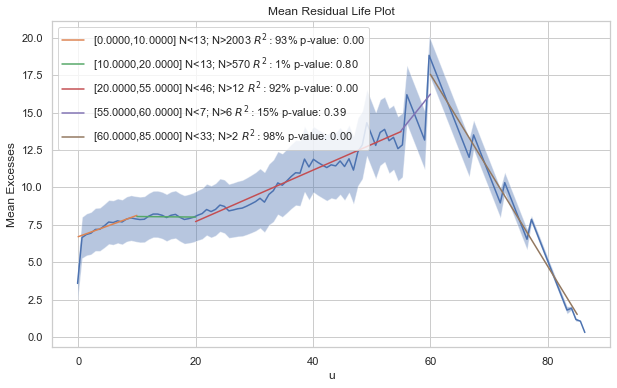

In [74]:
thold = Threshold(data)
splits = [0, 10, 20, 55, 60, 85]
thold.MRL(splits=splits)
plt.show()

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


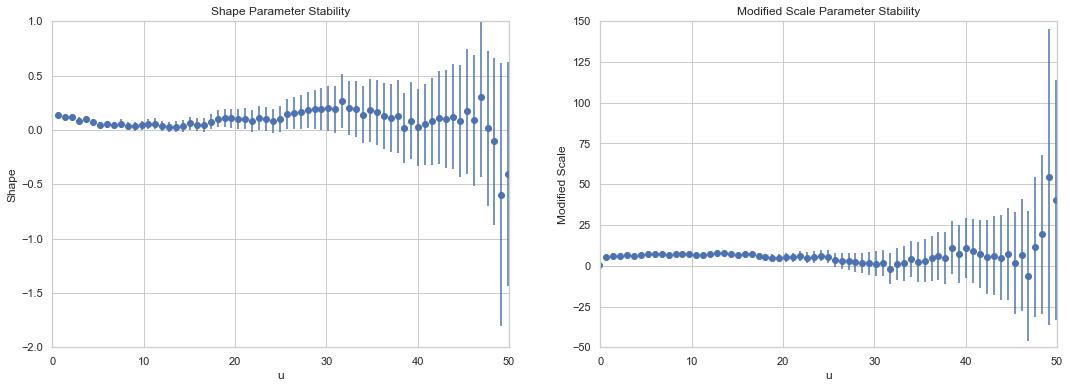

In [21]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=20, fig=fig, axs=axs)
axs[0].set_xlim((0,50))
axs[0].set_ylim((-2,1))
axs[1].set_xlim((0,50))
axs[1].set_ylim((-50,150))
plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


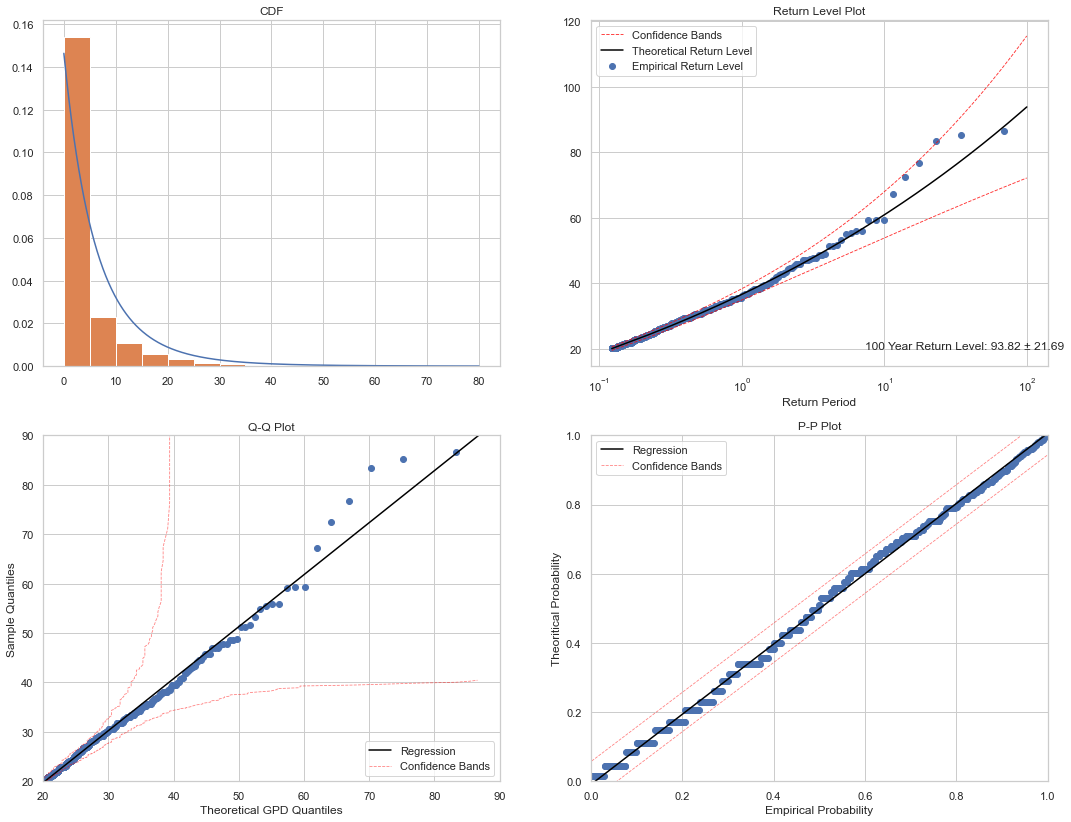

In [22]:
fit, _, over_thresh = thold.fit(thold=20)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, 80, 1000)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(data, bins=np.arange(0,80,5), density=True, label='Data')
ax1.set_title('CDF')

thold.return_value(thold=20, fig=fig, ax=ax2)

thold.qqplot(thold=20, fig=fig, ax=ax3)
thold.ppplot(thold=20, fig=fig, ax=ax4)

ax3.set_xlim((20,90))
ax3.set_ylim((20,90))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

### Threshold Modeling: S&P500 ###

Now we'll turn the approach once again to the daily log returns of the S&P 500. These returns are again *two-tailed*, so we must find parameters for both tails. There are several approaches we can take, none of which are ideal:

1. Take absolute values and apply the resulting parameters in both tails
2. Take the values as is, finding the right tail parameters, then flip and find the left tail parameters. A symmetric distribution could be created from the average of the two or an assymetric one could utilize separate params in each tail.
3. Split the data into separate subsets, one postive and one negative and fit each dataset.

Currently, DBLGP supports only one set of Pareto parameters, so we will implement for a symmetric distribution.

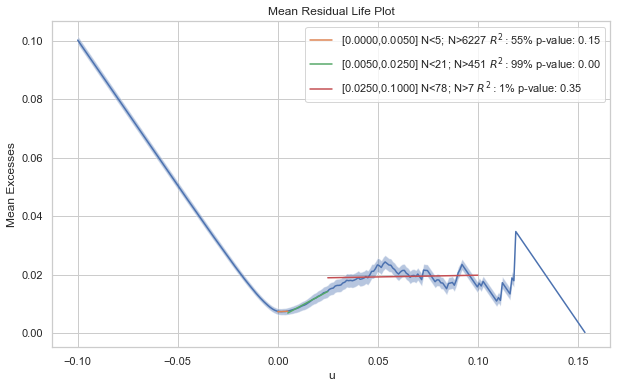

In [23]:
thold = Threshold(sp_lret)
splits = [0, .005, .025, .1]
thold.MRL(splits=splits)
plt.show()

The residuals plot doesn't provide as clear an indication with this dataset, although .5% continuous return is a good starting point. The parameter stability as both the shape and scale paramters are invariant well past .5%.

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


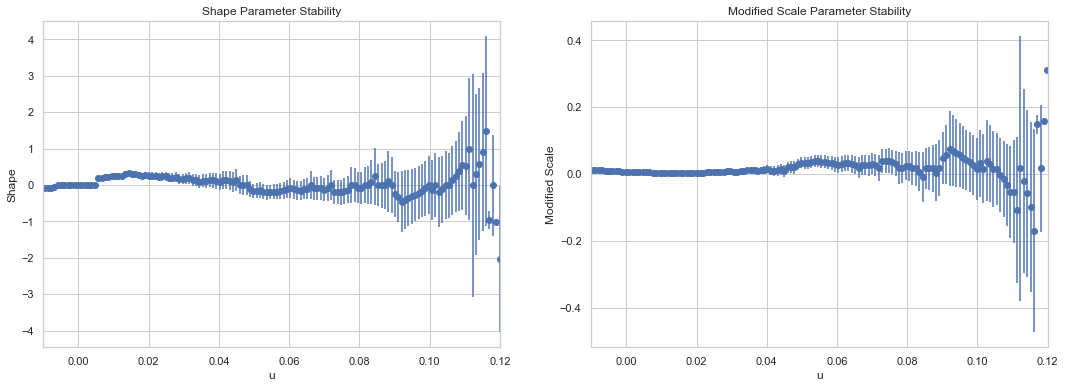

In [24]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=5, fig=fig, axs=axs)
axs[0].set_xlim((-0.01, .12))
axs[1].set_xlim((-0.01, .12))
plt.show()

Both parameters are quite stable out to 3% and even beyond. So without anything more conclusive, we will fit two separate Paretos on either end of the range: 

$loc_1 = .02$ 
and 
$loc_2 = .005$

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


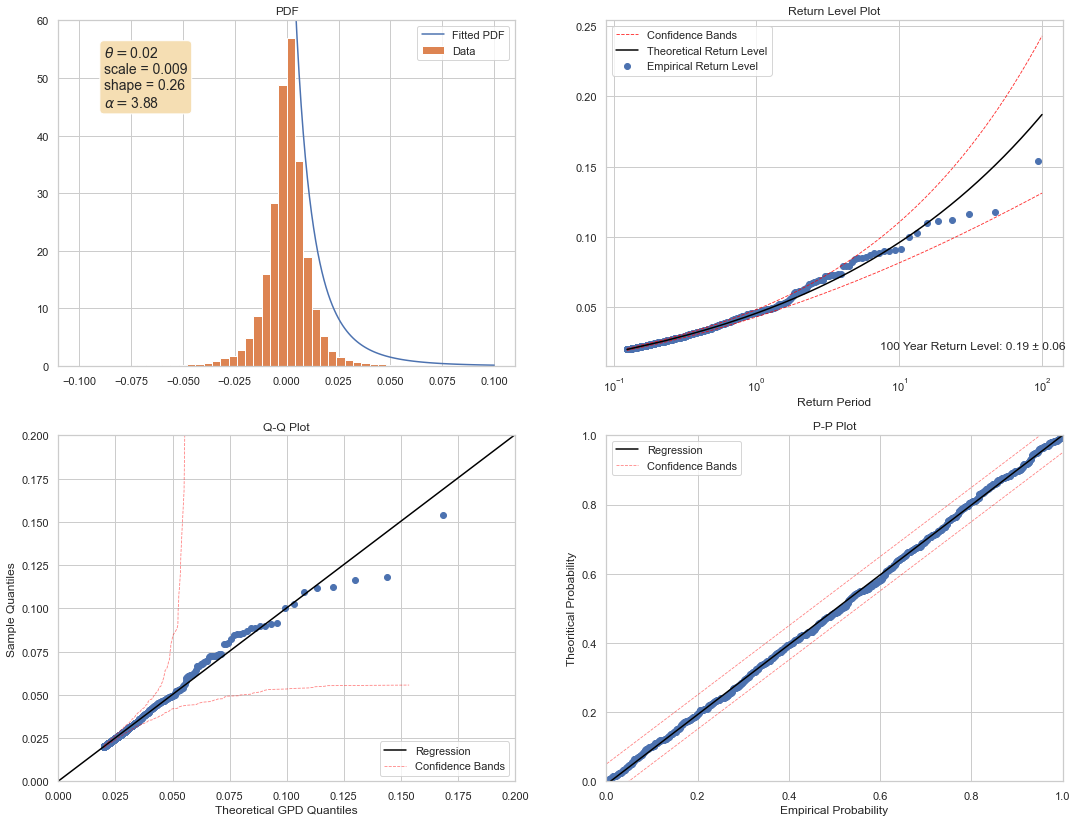

In [25]:
thresh = 0.02
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


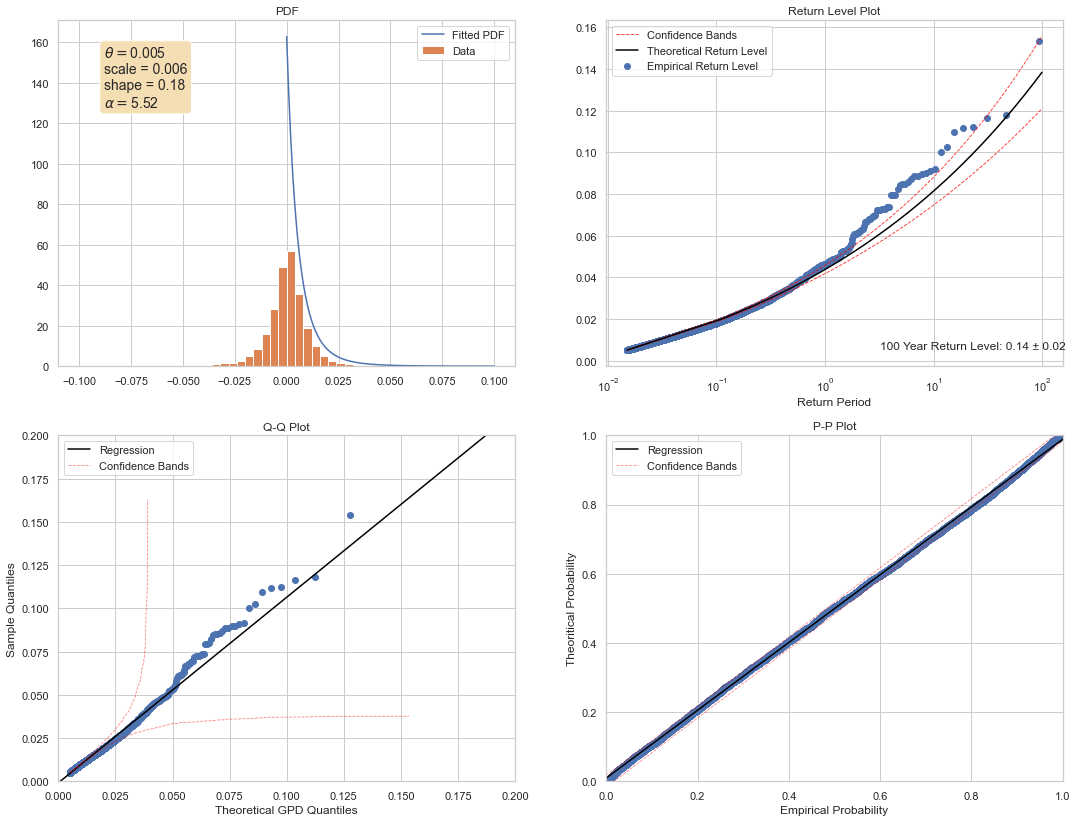

In [26]:
thresh = .005
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')

counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

# ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

Right away we can see a trade-off between the two thresholds:

+ the higher threshold provides a better fit deeper in the tails, however, the body is less appropriate
+ the lower threshold is a worse fit deep in the tails, however, the body is a closer fit

As discussed, we'll use the fitted parameters in both tails of our double Pareto to simulate a share price movement, which we overlay over the dataset below.

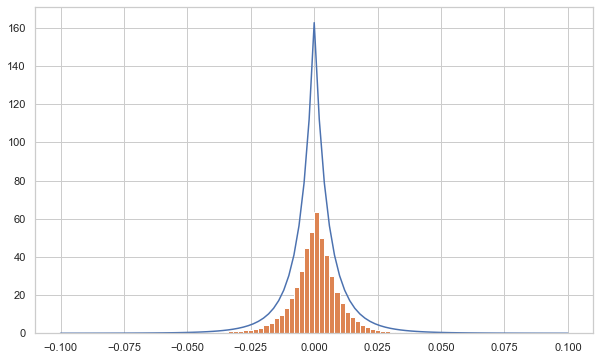

In [27]:
dbl = DBLGP()

x = np.linspace(-.1, .1, 101)

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.plot(x, dbl.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax.hist(thold.data, bins=np.linspace(-.1,.1,101), density=True, label='Data')

ax1.set_title('PDF')

plt.show()

Below is a single sample path:

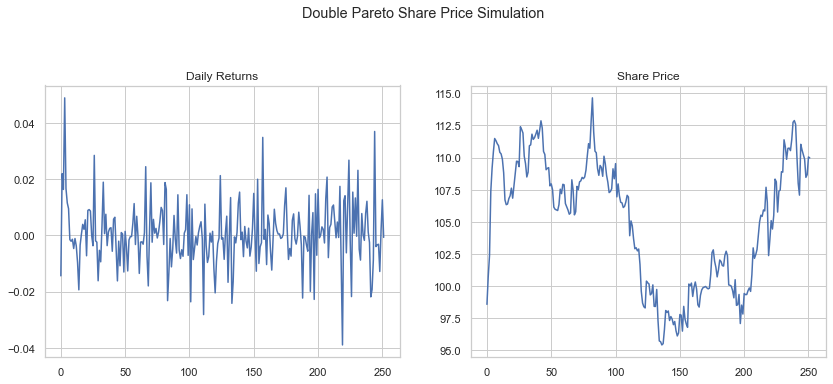

In [28]:
days = 252
x = np.arange(days)
logrets = dbl.rvs(size=x.shape, shape=shape, scale=scale)
rets = np.exp(logrets)
S0 = 100
S = S0*rets.cumprod()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, (rets - 1).reshape(-1,1))
ax2.plot(x, S)

ax1.set_title('Daily Returns')
ax2.set_title('Share Price')

plt.suptitle('Double Pareto Share Price Simulation', y=1.1)
plt.show()

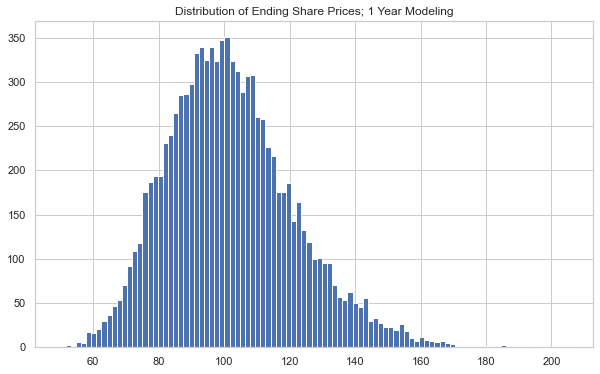

In [29]:
n = 10000
x = np.arange(days)
dbl = DBLGP()

logrets = dbl.rvs(shape, scale=scale, size=(n, days))
rets = np.exp(logrets) - 1
S0 = 100
S = S0*np.exp(logrets).cumprod(axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,6))

counts, bins, _ = ax.hist(S[:, -1], bins=np.linspace(50, S[:, -1].max(), 100))

ax.set_title('Distribution of Ending Share Prices; 1 Year Modeling')
plt.show()

### Threshold Analysis for PHAT ###

Earlier we used threshold analysis to estimate tail characteristics of the positive tail log daily returns in the S&P 500, then we assumed similar characteristics in the left tail. This time around, we will repeat the analysis with the data reflected, to see if it results in different parameters.

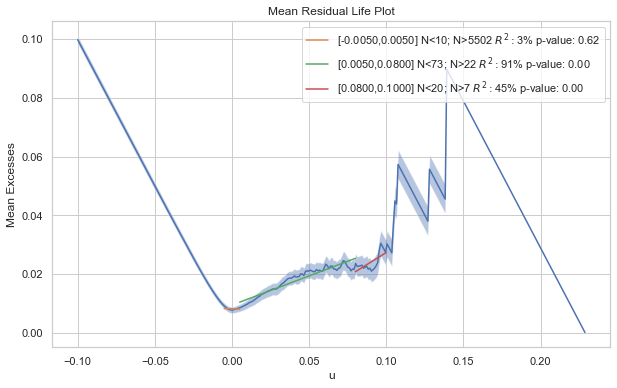

In [41]:
thold = Threshold(-sp_lret)
splits = [-.005, .005, .08, .1]
thold.MRL(splits=splits)
plt.show()

Above we see good linear approximations through 0.5% daily returns all the way out to 8%.

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


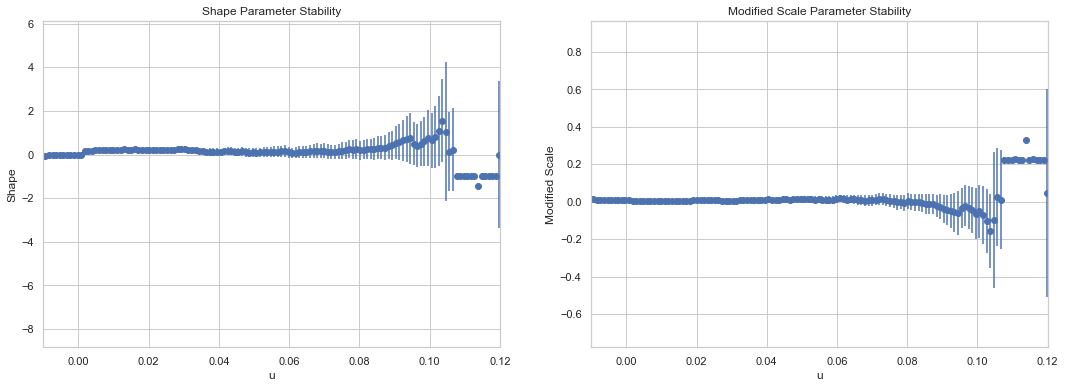

In [42]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=5, fig=fig, axs=axs)
axs[0].set_xlim((-0.01, .12))
axs[1].set_xlim((-0.01, .12))
plt.show()

In the parameter stability we see both the scale and shape parameters start to breakdown in the 6% to 7% range.

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


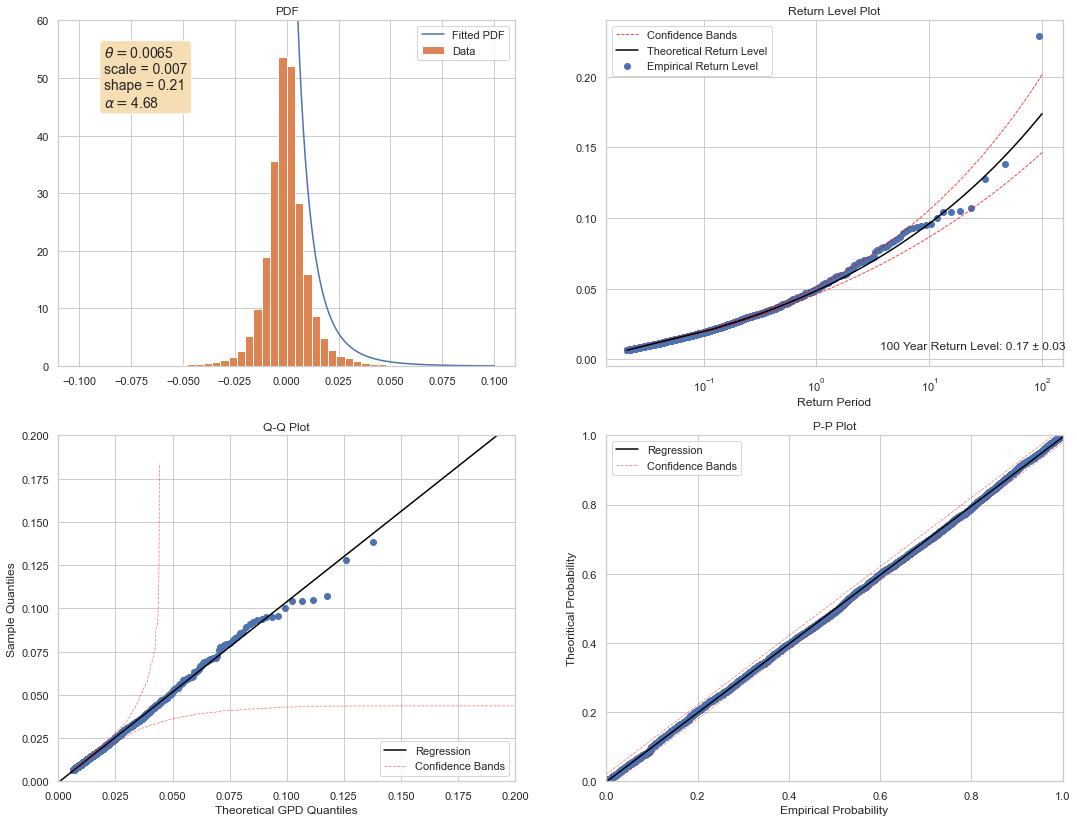

In [43]:
thresh = 0.0065
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


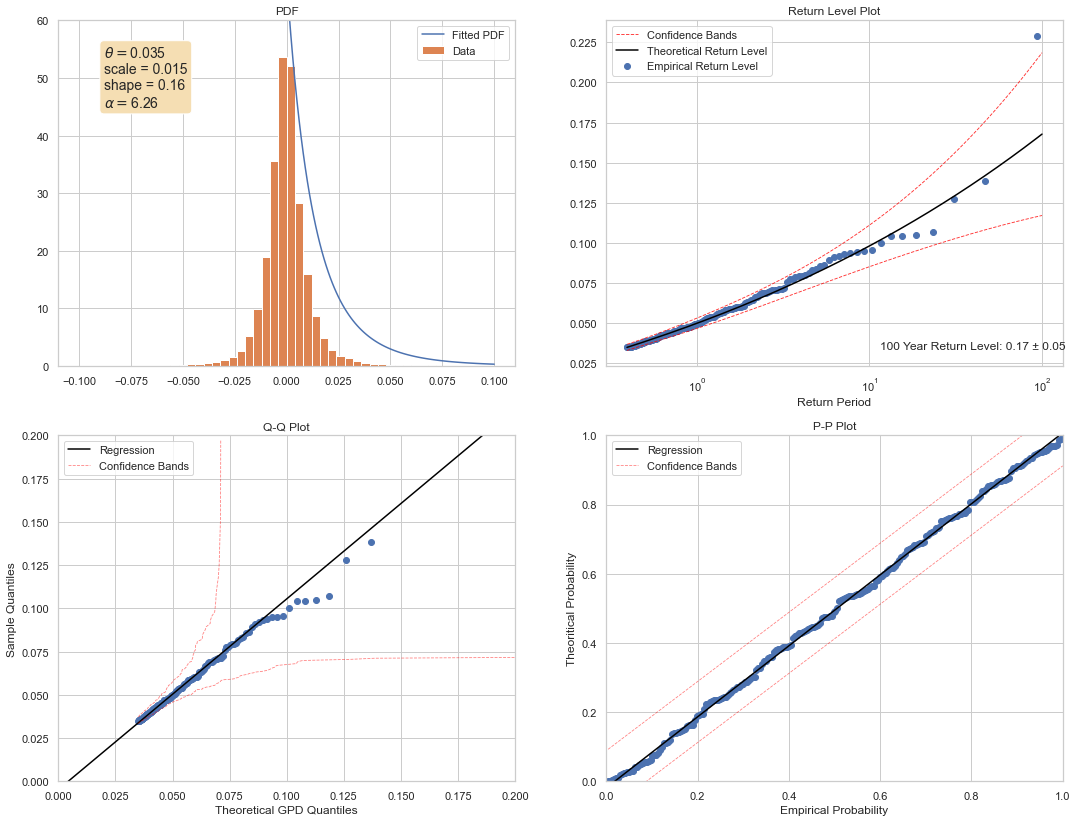

In [44]:
thresh = 0.035
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

Interestingly, the trade-off between tail thickness is less dramatic to the downside.

### Finding the Middle Ground ###

Of course, with the PHAT model, we not only have the two Pareto distributions in the tails to estimate. We must also estimate the Gaussian in the body!

To do so, we will simply filter out the observations outside of the tail thresholds. For this process, we will choose symmetrical thresholds, as they would otherwise skew the resulting normal in either direction. We will select tail thresholds as follows:

+ $\theta_l, \theta_r = -0.035, 0.035$
+ $\theta_l, \theta_r = -0.015, 0.015$
+ $\theta_l, \theta_r = -0.01, 0.01$

In [45]:
tholds = np.array([.0035, .005, .00625, .0075, .01, .5])
tholds = np.vstack((-tholds, tholds)).T

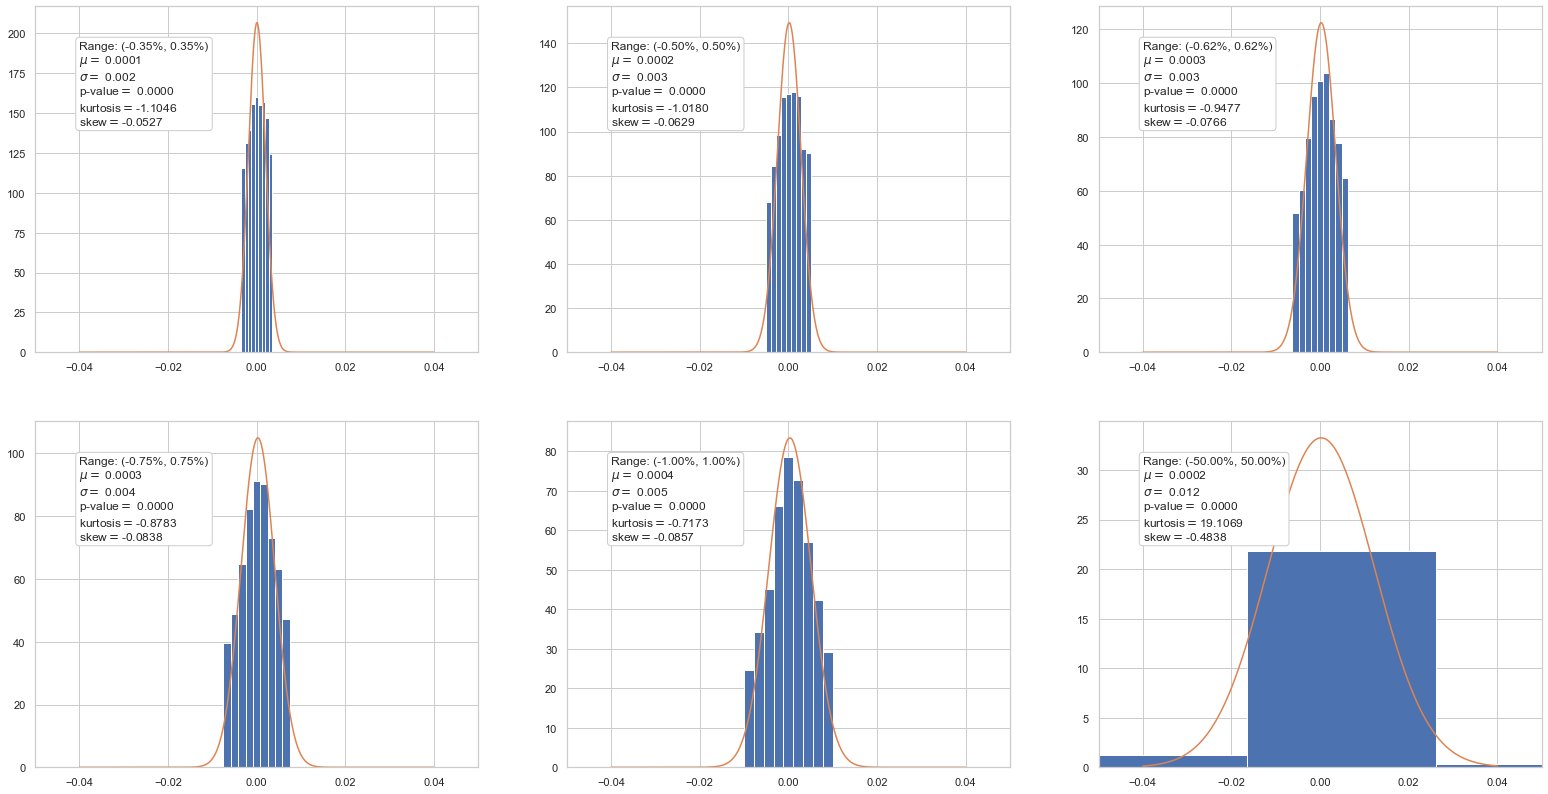

In [46]:
x = np.linspace(-.04, .04, 1000)

fig, axs = plt.subplots(2,3,figsize=(27,14))
axs = axs.flatten()
fits = []
for i in range(axs.size):
    ax = axs[i]
    loc_l, loc_r = tholds[i]
    body_rets = sp_lret[(sp_lret>loc_l) & (sp_lret<loc_r)]
    mean, std = scist.norm.fit(body_rets)
    fits.append((mean, std))
    _, p_value = scist.normaltest(body_rets)
    kurt = scist.kurtosis(body_rets)
    skew = scist.skew(body_rets)
    
    bins = np.linspace(body_rets.min(), body_rets.max(), 10)
    ax.hist(body_rets, bins=bins, density=True)
    ax.plot(x, scist.norm.pdf(x, mean, std))

    ax.set_xlim((-.05, .05))
    txt = f'Range: ({loc_l:.2%}, {loc_r:.2%})'
    txt += '\n'    
    txt += r'$\mu = $ ' + f'{mean:.4f}'
    txt += '\n'
    txt += r'$\sigma = $ ' + f'{std:.3f}'
    txt += '\n'
    txt += r'p-value$ = $ ' + f'{p_value:.4f}'
    txt += '\n'
    txt += r'kurtosis$ = $' + f'{kurt:.4f}'
    txt += '\n'
    txt += r'skew$ = $' + f'{skew:.4f}'

    ax.text(
        .1, .9, txt, transform=ax.transAxes, ha='left', va='top',
        bbox=dict(boxstyle='round', ec='.8', fc='w')
    )


plt.show()

We also include the full range for comparison purposes.

First note the ***sinister*** nature of fitting to the normal distribution. Every fit has a p-value with significance > .0001%, yet when we look at the entire distribution, the kurtosis is 10-100x larger. When we fit to a normal, that kurtosis is lost and investors are exposed significant tail risk.

Note that the range of means is very narrow, and the standard deviation increases as we broaden the range.

The kurtosis and skew appear to be minimized around .02% daily continuous returns.

From the above we note a few things:

+ first, notice the improvement in fit versus 
+ the left and right junction points create a very narrow range for the Guassian body of the distribution. The Gaussian simply arrests the explosive assymptotic behavior of the Pareto as it approaches the mean. The flattening of the head results in more (but not many more!) observations are pushed well out into the tails. In this sense, the Gaussian is more of a capstone than a body.
+ the capstone effect of driving observations into the tails is accomplished by a dramatically higher scaling factor for the Pareto tails than was estimated via the threshold analysis. the sound fit here is empirical support of the primacy of the tail index over other factors.

Another decent test of fit is to compare the number of observations in data at certain thresholds versus a random sample from the fit. Here we compare for 100,000 samples:

In [51]:
n = 100000
logrets = dist.rvs(size=n)

(np.abs(logrets) < .01).sum() / logrets.size, (sp_lret.abs() < .01).sum() / sp_lret.size

(0.74306, 0.7584327086882453)

In [53]:
(np.abs(logrets) < .001).sum() / logrets.size, (sp_lret.abs() < .001).sum() / sp_lret.size

(0.10731, 0.1198892674616695)

In [54]:
f'{(np.abs(logrets) > .1).sum() / logrets.size:.3E}', f'{(sp_lret.abs() > .1).sum() / sp_lret.size:.3E}'

('2.600E-04', '5.963E-04')

Here we see strong consistency with observations. In fact, our tail events above 10% daily return happen a fair amount MORE frequently, which I believe Taleb would agree to err on in terms of caution.

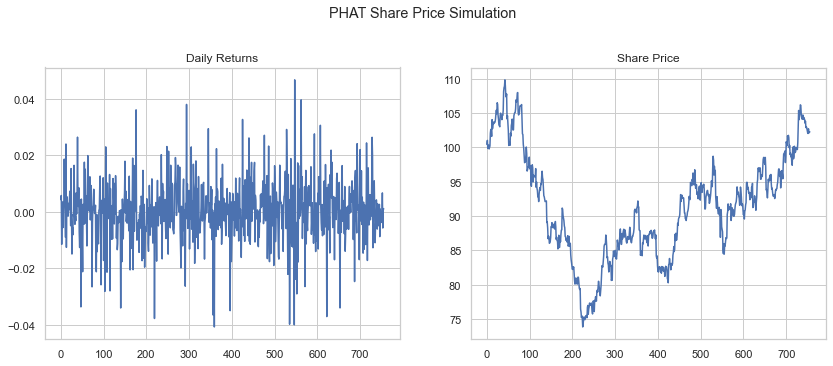

In [55]:
days = 252*3
x = np.arange(days)

logrets = dist.rvs(size=x.shape)
rets = np.exp(logrets)
S0 = 100
S = S0*rets.cumprod()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, (rets - 1).reshape(-1,1))
ax2.plot(x, S)

ax1.set_title('Daily Returns')
ax2.set_title('Share Price')

plt.suptitle('Phat Share Price Simulation', y=1.05)
plt.show()

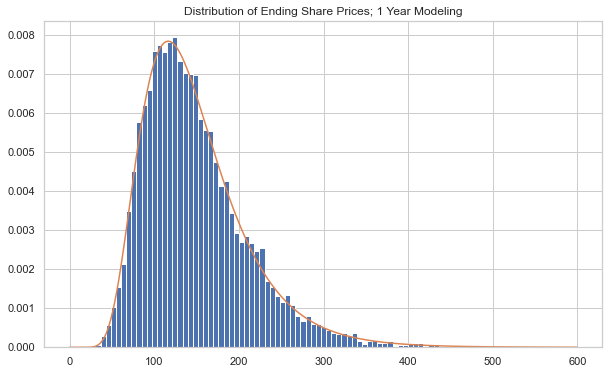

In [150]:
n = 10000
logrets = dist.rvs(size=(n, days*5))
rets = np.exp(logrets)
S0 = 100
S = (S0)*rets.cumprod(axis=1)
lnorm = scist.lognorm(*scist.lognorm.fit(S[:, -1]))

fig, ax = plt.subplots(1,1,figsize=(10,6))

counts, bins, _ = ax.hist(S[:, -1], bins=np.linspace(0, S[:, -1].max(), 100), density=True)
x = np.linspace(0,S[:, -1].max(), 1000)
ax.plot(x, lnorm.pdf(x))

ax.set_title('Distribution of Ending Share Prices; 1 Year Modeling')
plt.show()